# Notebook to investigate estimating admixture times (likelihood funcs also go in here)

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
# from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective, loss_wrapper
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv, run_cvq, run_cv_joint

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
plt.rcParams['axes.axisbelow'] = True
plt.style.use('bmh')
rng = np.random.default_rng(2024)

In [ ]:
def get_FEEMS_demes_nll_w_c_t(x, sp_graph, obj, lrn):
    c = x[0]; tau = x[1]#*np.median(1/sp_graph.q)
    
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

    #TODO: consider dividing the weights by the maximum to get it to lower levels as higher migmat means higher prob of diffusion, etc.?
    migmat = deepcopy(sp_graph.W.todense()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
    # migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    probmat = sp.linalg.expm(migmat*tau)

    s = lrn[0][0]; d = lrn[0][1]

    onehot = np.zeros(sp_graph.n_observed_nodes); onehot[s] = 1
    ps = np.ravel(onehot @ probmat)

    onehot[s] = 0; onehot[d] = 1
    pd = np.ravel(onehot @ probmat)

    # for i in range(0,sp_graph.n_observed_nodes):
    #     for j in range(i+1,sp_graph.n_observed_nodes):
    #         resmat[i,j] = Rmat[i,s] * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j] \
    #                                 - 0.5*c*pd[i] - 0.5*ps[i] + 0.5*c*pd[i]**2 + 0.5*ps[i]**2 + 0.5*pd[i]*ps[i] + 0.5*c*pd[i]*ps[i]) + \
    #                     Rmat[j,s] * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j] \
    #                                 - 0.5*c*pd[j] - 0.5*ps[j] + 0.5*c*pd[j]**2 + 0.5*ps[j]**2 + 0.5*pd[j]*ps[j] + 0.5*c*pd[j]*ps[j]) + \
    #                     Rmat[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j] \
    #                                 - 0.5*pd[i]*ps[i] + 0.5*s*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*c**2*pd[i]**2 - 0.5*pd[j]*ps[j] \
    #                                 + 0.5*c*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*c**2*pd[j]**2) + \
    #                     Rmat[i,d] * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j] \
    #                                 - 0.5*c*pd[i]*ps[i] + 0.5*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*pd[i]**2 - 0.5*pd[i] + 0.5*c*pd[i]) + \
    #                     Rmat[j,d] * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i] \
    #                                 - 0.5*c*pd[j]*ps[j] + 0.5*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*pd[j]**2 - 0.5*pd[j] + 0.5*c*pd[j]) + \
    #                     Rmat[i,j] * (ps[i]*ps[j] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) + \
    #                     (ps[i] + ps[j] + c*pd[i] + c*pd[j])/sp_graph.q[s] + \
    #                     ((1-c)*pd[i] + (1-c)*pd[j])/sp_graph.q[d] + \
    #                     (1 - ps[i] - pd[i])/sp_graph.q[i] + (1 - ps[j] - pd[j])/sp_graph.q[j] + 2*tau
    #         resmat[j,i] = resmat[i,j]

    for i in range(0,sp_graph.n_observed_nodes):
        for j in range(i+1,sp_graph.n_observed_nodes):
            pid = pd[i]; pjd = pd[j]
            pis = ps[i]; pjs = ps[j]
            resmat[i,j] = (1.*pid - 1.*c*pid + 1.*pjd - 1.*c*pjd)/sp_graph.q[d] + (1. - 1.*pid - 1.*pis)/sp_graph.q[i] + \
                (1. + pid - 2.*pis**2 - 2.*pjd - pid*pjd + 1.*pjd**2 - 1.*pjs - pid*pjs + 2.*pis*pjs + 1.*pjd*pjs)/sp_graph.q[j] + \
                (1.*c*pid + 1.*pis - 2.*pis**2 + 1.*c*pjd + 1.*pjs + 2.*pis*pjs)/sp_graph.q[s] + \
                (-0.5*pid + 0.5*c*pid + 0.5*pid**2 - 0.5*c*pid**2 + 0.5*pid*pis - 0.5*c*pid*pis + 1.*pjd - 1.*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd - 1.*pis*pjd + 1.*c*pis*pjd)*Rmat[i,d] + \
                (1. - 1.*pid - 1.*pis - 1.*pjd + 1.*pid*pjd + 1.*pis*pjd - 1.*pjs + 1.*pid*pjs + 1.*pis*pjs)*Rmat[i,j] + \
                (-0.5*c*pid + 0.5*c*pid**2 - 0.5*pis + 0.5*pid*pis + 0.5*c*pid*pis + 0.5*pis**2 + 1.*c*pjd - 1.*c*pid*pjd - 1.*c*pis*pjd + 1.*pjs - 1.*pid*pjs - 1.*pis*pjs)*Rmat[i,s] + \
                (1.*pid - 1.*c*pid - 0.5*pjd + 0.5*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd + 0.5*pjd**2 - 0.5*c*pjd**2 - 1.*pid*pjs + 1.*c*pid*pjs + 0.5*pjd*pjs - 0.5*c*pjd*pjs)*Rmat[j,d] + \
                (1.*c*pid + 1.*pis - 1.*pis**2 - 0.5*c*pjd - 1.*c*pid*pjd - 1.*pis*pjd + 0.5*c*pjd**2 - 0.5*pjs - 1.*c*pid*pjs + 0.5*pjd*pjs + 0.5*c*pjd*pjs + 0.5*pjs**2)*Rmat[j,s] + \
                (-0.5*c*pid**2 + 0.5*c**2*pid**2 - 0.5*pid*pis + 0.5*c*pid*pis + 2.*c*pid*pjd - 2.*c**2*pid*pjd + 1.*pis*pjd - 1.*c*pis*pjd - 0.5*c*pjd**2 + 0.5*c**2*pjd**2 + 1.*pid*pjs - 1.*c*pid*pjs - 0.5*pjd*pjs + 0.5*c*pjd*pjs)*Rmat[s,d] + \
                4*tau + 2*pid*tau - 8*pis**2*tau - 2*pjd*tau - 2*pid*pjd*tau + 2*pjd**2*tau - 2*pid*pjs*tau + 8*pis*pjs*tau + 2*pjd*pjs*tau
            resmat[j,i] = resmat[i,j]

    # for i in range(0,sp_graph.n_observed_nodes):
    #     for j in range(i,sp_graph.n_observed_nodes):
    #         pid = pd[i]; pjd = pd[j]
    #         pis = ps[i]; pjs = ps[j]
    #         resmat[i,j] = (1.*pid-1.*c*pid+1.*pjd-1.*c*pjd)*1/sp_graph.q[d]+(1.-1.*pid-1.5*pis-0.5*pid*pjd+0.5*pjd**2+0.5*pjs-0.5*pid*pjs+0.5*pjd*pjs)*1/sp_graph.q[i]+(1.+1.*pid+0.5*pis-2.*pis**2-2.*pjd-0.5*pid*pjd+0.5*pjd**2-1.5*pjs-0.5*pid*pjs+2.*pis*pjs+0.5*pjd*pjs)*1/sp_graph.q[j]+(1.*c*pid+1.*pis-2.*pis**2+1.*c*pjd+1.*pjs+2.*pis*pjs)*1/sp_graph.q[s]+(-0.25*pid+0.25*c*pid+0.25*pid**2-0.25*c*pid**2+0.25*pid*pis-0.25*c*pid*pis+0.75*pjd-0.75*c*pjd-1.*pid*pjd+1.*c*pid*pjd-1.*pis*pjd+1.*c*pis*pjd+0.25*pjd**2-0.25*c*pjd**2+0.25*pjd*pjs-0.25*c*pjd*pjs)*Rmat[i,d]+(0.5-0.25*pid-0.25*pid**2-0.5*pis-0.5*pid*pis-0.25*pis**2-0.75*pjd+0.75*pid*pjd+1.*pis*pjd-0.5*pjs+0.75*pid*pjs+1.*pis*pjs-0.25*pjd*pjs-0.25*pjs**2)*Rmat[i,j]+(-0.25*c*pid+0.25*c*pid**2-0.25*pis+0.25*pid*pis+0.25*c*pid*pis+0.25*pis**2+0.75*c*pjd-1.*c*pid*pjd-1.*c*pis*pjd+0.25*c*pjd**2+0.75*pjs-1.*pid*pjs-1.*pis*pjs+0.25*pjd*pjs+0.25*c*pjd*pjs+0.25*pjs**2)*Rmat[i,s]+(0.75*pid-0.75*c*pid+0.25*pid**2-0.25*c*pid**2+0.25*pid*pis-0.25*c*pid*pis-0.25*pjd+0.25*c*pjd-1.*pid*pjd+1.*c*pid*pjd+0.25*pjd**2-0.25*c*pjd**2-1.*pid*pjs+1.*c*pid*pjs+0.25*pjd*pjs-0.25*c*pjd*pjs)*Rmat[j,d]+(0.75*c*pid+0.25*c*pid**2+0.75*pis+0.25*pid*pis+0.25*c*pid*pis-0.75*pis**2-0.25*c*pjd-1.*c*pid*pjd-1.*pis*pjd+0.25*c*pjd**2-0.25*pjs-1.*c*pid*pjs+0.25*pjd*pjs+0.25*c*pjd*pjs+0.25*pjs**2)*Rmat[j,s]+(-0.5*c*pid**2+0.5*c**2*pid**2-0.5*pid*pis+0.5*c*pid*pis+2.*c*pid*pjd-2.*c**2*pid*pjd+1.*pis*pjd-1.*c*pis*pjd-0.5*c*pjd**2+0.5*c**2*pjd**2+1.*pid*pjs-1.*c*pid*pjs-0.5*pjd*pjs+0.5*c*pjd*pjs)*Rmat[s,d] + 4*tau+10*pid*tau+8*pis*tau-8*pis**2*tau+6*pjd*tau-10*pid*pjd*tau-8*pis*pjd*tau+2*pjd**2*tau+8*pjs*tau-10*pid*pjs*tau+2*pjd*pjs*tau
    #         resmat[j,i] = resmat[i,j]

    resmat += np.diag(np.repeat(tau,sp_graph.n_observed_nodes))
    # resmat += np.diag(1/sp_graph.q+2*tau)

    # D = squareform(pdist(sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu)),"sqeuclidean"))/1000
    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

    plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)

    # return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)], (2*sp_graph.n_snps*C @ sp_graph.S @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)])[2]
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)#, -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2], -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]  
    # tempS = 2*sp_graph.n_snps*C @ sp_graph.S @ C.T; tempS[np.diag_indices(sp_graph.n_observed_nodes-1)] = 50000

    # tempR = -C @ resmat @ C.T; tempR[np.diag_indices(sp_graph.n_observed_nodes-1)] = 500
    # return -sp.stats.wishart.logpdf(tempS, sp_graph.n_snps, tempR), -sp.stats.linregress(tempR[np.tril_indices(sp_graph.n_observed_nodes-1,-1)], tempS[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]

In [ ]:
def get_FEEMS_hao_nll_w_c_t(x, sp_graph, obj, lrn):
    c = x[0]; tau = x[1]#*np.median(1/sp_graph.q)

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    # resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

    Tstar = Rmat + (Q1mat + Q1mat.T); Tstar[np.diag_indices(sp_graph.n_observed_nodes)] = 0
    dT0 = np.zeros_like(Tstar)
    dT0[lrn[0][0],lrn[0][1]] = c*Tstar[lrn[0][0],lrn[0][0]] - c*Tstar[lrn[0][0],lrn[0][1]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 2*c/sp_graph.q[lrn[0][0]]
    dT0[lrn[0][1],lrn[0][0]] = dT0[lrn[0][0],lrn[0][1]]
    for i in list(set(range(dT0.shape[0]))-set([lrn[0][0],lrn[0][1]])):
    # for i in list(set(range(dT0.shape[0]))-set([lrn[0][1]])):
        # dT0[i,lrn[0][1]] = c*Tstar[i,lrn[0][0]] - c*Tstar[i,lrn[0][1]]; dT0[lrn[0][1],i] = dT0[i,lrn[0][1]]
        dT0[i,lrn[0][1]] = c*Tstar[i,lrn[0][0]] - c*Tstar[i,lrn[0][1]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]]; dT0[lrn[0][1],i] = dT0[i,lrn[0][1]]
    # dT0[lrn[0][1],lrn[0][1]] = c**2 * Tstar[lrn[0][0],lrn[0][0]] + 2*c*(1-c)*Tstar[lrn[0][0],lrn[0][1]] + (c**2-2*c) * Tstar[lrn[0][1],lrn[0][1]] 
    dT0[lrn[0][1],lrn[0][1]] = c*Tstar[lrn[0][0],lrn[0][0]] - c*Tstar[lrn[0][1],lrn[0][1]] 
    # plt.imshow(dT0); plt.colorbar(); plt.show()

    dTt = -tau*(np.diag(1/sp_graph.q)@np.diag(np.diag(dT0)) + obj.Linv@dT0 + dT0@obj.Linv) + dT0

    resmat = Tstar+dTt+tau
    # - np.ones((sp_graph.n_observed_nodes,1)) @ (Tstar+dTt).diagonal().reshape(1,-1) - (Tstar+dTt).diagonal().reshape(-1,1) @ np.ones((1,sp_graph.n_observed_nodes))

    # resmat -= np.diag(np.repeat(tau,sp_graph.n_observed_nodes))
    # resmat[np.diag_indices_from(resmat)] = 0.01
    # resmat += np.diag(1/sp_graph.q+2*tau)

    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

    # plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    # plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    # plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    # plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -2*C @ resmat @ C.T),2),round(sp.stats.linregress((-2*C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)

    # return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    # return -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)], (-sp_graph.n_snps*C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)])[2] #-sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), 
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -2*C @ resmat @ C.T)#, -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2], -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]  
    # tempS = 2*sp_graph.n_snps*C @ sp_graph.S @ C.T; tempS[np.diag_indices(sp_graph.n_observed_nodes-1)] = 50000

    # tempR = -C @ resmat @ C.T; tempR[np.diag_indices(sp_graph.n_observed_nodes-1)] = 500
    # return -sp.stats.wishart.logpdf(tempS, sp_graph.n_snps, tempR), -sp.stats.linregress(tempR[np.tril_indices(sp_graph.n_observed_nodes-1,-1)], tempS[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]

In [ ]:
# estdf.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.show()
# estdf.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2],labels=['no admix. (top)','no admix. (random)'],rotation=30); plt.show()
# estdf.boxplot(column='cest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# estdf.boxplot(column='ciest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2],labels=['no admix. (top)','no admix. (random)'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# estdf.boxplot(column='ciest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$ (assuming $\tau=0$)'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# estdf.assign(lldiff=lambda x: x.llc-x.llc0).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.ylabel('diff. in log-lik units b/w instantaneous & null models'); plt.axhline(6.6,color='grey',ls='--'); plt.show()
# np.sum((estdf['llc']-estdf['llc0']).iloc[np.where(estdf['tsim']==-1)]<5)
# estdf['lre'].iloc[np.where((estdf['llc']-estdf['llc0']).iloc[np.where(estdf['tsim']==-1)]>0.6)[0]]
# estdf.assign(lldiff=lambda x: x.llct-x.llc).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.ylabel('diff. in log-lik units b/w joint & instantaneous models'); plt.ylim((0,5)); plt.axhline(4,color='grey',ls='--'); plt.show()
# estdf.assign(lldiff=lambda x: x.llct-x.llc)
# plt.hist(sp_graph.q); 

## Simulating an older admixture event to see whether it gets detected
### 1. Complete, dense sampling
### 2. Variable, sparse sampling

In [2]:
# def sim_var_sparse(nsnps, c, sparsity):
#     sampnodes = np.sort(np.unique(np.random.choice(97,sparsity,replace=False).tolist()+[51,44])).tolist()#[2,14,18,25,31,44,46,51,57,66,74,77]
#     ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
#     graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., 
#                                                            barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
#     n_e = 10**(1+np.random.random(96)*3)
#     gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=nsnps, n_print=int(0.8*nsnps), long_range_nodes=[(51,44)], admixture_props=[c], n_e=n_e, time_of_adm=[10])

#     return [gen_test_80, ss, n_e, coord_def]
    
# sims = Parallel(n_jobs=16)(delayed(sim_var_sparse)(1000,0.5,16) for _ in range(16))

graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=8, option=1, n_samples_per_node=10)
foo = lambda c: [simulate_genotypes_w_admixture(graph_def, target_n_snps=2000, n_print=800, long_range_nodes=[(51,44)], admixture_props=[0.5], n_e=100, time_of_adm=[10])]
sims = Parallel(n_jobs=16)(delayed(foo)(0.5) for _ in range(16))

In [3]:
for rep in range(16):
    sp_graph = SpatialGraph(sims[rep][0], coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=2.,optimize_q='n-dim',lamb_q=1., verbose=False)

    top = sp_graph.extract_outliers(fdr=0.25, verbose=False)
    if top is None:
        print('no outliers in rep {:d}'.format(rep))

    df = sp_graph.calc_contour(destid=44, search_area='all', exclude_boundary=True)
    
    print(df['(source, dest.)'].iloc[np.argmax(df['log-lik'])][0], df['admix. prop.'].iloc[np.argmax(df['log-lik'])])
    print(df['scaled log-lik'].iloc[np.where(df['(source, dest.)']==(51,44))[0]].values[0])    
    print(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Using a FDR of 0.25: 39 outlier deme pairs found
Putative destination demes: [44]
  Optimizing likelihood over 59 demes in the graph...25%...50%...done!
26 0.2162115889532034
-10.037777902325615
[2.         1.73205081]
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Using a FDR of 0.25: 40 outlier deme pairs found
Putative destination demes: [44]
  Optimizing likelihood over 59 demes in the graph...25%...50%...done!
37 0.21136211056123647
-5.109705477429088
[1.5        2.59807621]
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Using a FDR of 0.25: 42 outlier deme pairs found
Putative destination demes: [44]
  Optimizing likelihood over 59 demes in the graph...25%...50%...done!
51 0.3475000101922749
0.0
[3.         3.46410162]
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Using a FDR

In [ ]:
results = pd.DataFrame(index=range(16), columns=['ss','n_e','lamb_cv','lamb_q_cv','baselinew','baselines2','outliers','baselinell',
                                                'mle_point_ll','mle_point_id','mle_point_c','mle_point_loc','all_point_ll','all_point_c',
                                                'mle_joint_ll','mle_joint_id','mle_joint_c','mle_joint_loc','all_joint_ll','all_joint_c'])

for rep in range(16):
    ## removing the source from the grid
    # coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    # gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    # results.loc[rep,'ss'] = sims[rep][1]
    # results.loc[rep,'n_e'] = sims[rep][2]
    
    ## creating the object
    # sp_graph = SpatialGraph(gen_test, coord, grid_def, edge_def)
    sp_graph = SpatialGraph(sims[rep][0], coord_def, grid_def, edge_def)
    
    lamb_grid = np.geomspace(1e-2,1e2,12,endpoint=True)[::-1]; lamb_q_grid = np.geomspace(1e-2,1e2,5,endpoint=True)[::-1]
    cv_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=10, factr=1e10, inner_verbose=False, outer_verbose=False)
    mean_cv_err = np.nanmean(cv_err, axis=0)
    lamb_q_cv = lamb_q_grid[np.where(mean_cv_err == np.nanmin(mean_cv_err))[0][0]]
    lamb_cv = lamb_grid[np.where(mean_cv_err == np.nanmin(mean_cv_err))[1][0]]

    results.loc[rep,'lamb_cv'] = lamb_cv
    results.loc[rep,'lamb_q_cv'] = lamb_q_cv

    ## baseline fit
    sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv, verbose=False); 
    obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    # store the baseline weights for plotting later
    results.loc[rep,'baselinew'] = sp_graph.w
    results.loc[rep,'baselines2'] = sp_graph.s2
    results.loc[rep,'baselinell'] = -obj.eems_neg_log_lik()

    top = sp_graph.extract_outliers(verbose=False)
    if top is None:
        continue

    ## store the # of unique occurrences 
    results.loc[rep,'outliers'] = [(top['dest.'].value_counts().idxmax(), top['dest.'].value_counts().iloc[0])]

    ## run the point estimation framework 
    df = sp_graph.calc_contour(destid=44, search_area='all', exclude_boundary=True)

    results.loc[rep,'mle_point_id'] = df['(source, dest.)'].iloc[np.argmax(df['log-lik'])][0]
    results.loc[rep,'mle_point_c'] = df['admix. prop.'].iloc[np.argmax(df['log-lik'])]
    results.loc[rep,'mle_point_ll'] = df['log-lik'].iloc[np.argmax(df['log-lik'])]
    results.loc[rep,'mle_point_loc'] = str(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
        
    ## storing all the point results 
    results.loc[rep,'all_point_c'] = df['admix. prop.'].to_string(index=False)
    results.loc[rep,'all_point_ll'] = df['log-lik'].to_string(index=False)
    
    ## running the joint estimation framework
    joint_df = sp_graph.calc_joint_contour(destid=44, search_area='all', exclude_boundary=True, lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv)

    ## what is the MLE deme (in the joint estimation framework)? 
    results.loc[rep,'mle_joint_id'] = joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]
    results.loc[rep,'mle_joint_c'] = joint_df['admix. prop.'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_ll'] = joint_df['log-lik'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_loc'] = str(sp_graph.nodes[joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]]['pos'])
    
    ## storing the joint results 
    results.loc[rep,'all_joint_c'] = joint_df['admix. prop.'].to_string(index=False)
    results.loc[rep,'all_joint_ll'] = joint_df['log-lik'].to_string(index=False)

    print(results[['lamb_cv','lamb_q_cv','baselinell','mle_point_ll','mle_joint_ll','mle_point_id','mle_joint_id','mle_point_c','mle_joint_c']])      

In [62]:
results.to_csv("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp_t10.csv")

In [58]:
# _, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., 
#                                                        barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=sims[rep][1])0

rep = 0
coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

sp_graph = SpatialGraph(gen_test, coord, grid_def, edge_def)
sp_graph.fit(lamb=.3,optimize_q='n-dim',lamb_q=1., verbose=False); 

# sp_graph.extract_outliers()

# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=None, edge_width=2, abs_max=2, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()

# sp_graph.fit(lamb=0.3,lamb_q=1.,optimize_q='n-dim',long_range_edges=[(51,44)],option='onlyc')
# sp_graph.c

sp_graph.calc_contour(destid=44)

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 59 demes in the graph...25%...50%...done!


,"(source, dest.)",admix. prop.,log-lik,scaled log-lik
1,"(13, 44)",0.291201,-546.921515,-13.504079
2,"(14, 44)",NaN,NaN,NaN
3,"(15, 44)",0.270138,-552.560363,-19.142927
4,"(16, 44)",0.374205,-573.221807,-39.804372
5,"(17, 44)",0.291583,-571.143445,-37.726009
6,"(18, 44)",0.279976,-587.714194,-54.296759
7,"(19, 44)",0.000000,-603.913882,-70.496447
8,"(20, 44)",0.111398,-603.688440,-70.271004
9,"(21, 44)",0.000000,-603.913882,-70.496447
10,"(22, 44)",0.000000,-603.913882,-70.496447


In [ ]:
## how many sims have a log-lik > 4 or p-val
# sp.stats.chi2.sf(6.6,1)
# pd.concat([estdf,ctest]).assign(lldiff=lambda x: x.llct-x.llc)[pd.concat([estdf,ctest]).assign(lldiff=lambda x: x.llct-x.llc)['lldiff']>3.3].groupby('tsim')['lldiff'].count()/16
# ctest['test'].loc[ctest['tsim']==10]
# plt.hist(ctest['test'].loc[ctest['tsim']==20]/np.mean(1/sp_graph.q),color='grey'); plt.hist(estdf['test'].loc[estdf['tsim']==0]/np.mean(1/sp_graph.q),color='blue'); plt.hist(ctest['test'].loc[ctest['tsim']==1]/np.mean(1/sp_graph.q),color='yellow')
# plt.plot(range(1,9),[0,0,1,0.95,1,1,1,0.6],'-o',color='lightgreen',label='0.01'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel(r'% of sims with $\tau \geq 0$ for a certain threshold'); plt.plot(range(1,9),[0,0,1,0.97,1,1,1,0.9375],'-o',color='green',label='0.05'); plt.legend(title='p-val'); plt.xlabel(r'simulated $\tau$ (in gens)')
# plt.plot(range(1,9),[0.625,0,1,1,1,1,1,1],'-o',color='lightgreen',label='0.01'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel(r'% of sims with significantly $\ell_{c>0} > \ell_{c=0}$'); plt.plot(range(1,9),[0.85,0,1,1,1,1,1,1],'-o',color='green',label='0.05'); plt.legend(title='p-val'); plt.xlabel(r'simulated $\tau$ (in gens)')
## TPR & FPR
# plt.plot(range(1,9),[0.5625,0,1,1,1,1,1,1],'-o',color=plt.get_cmap('Blues',4)(3),label='0.01'); plt.plot(range(1,9),[0.625,0,1,1,1,1,1,1],'-o',color=plt.get_cmap('Blues',4)(2),label='0.1'); plt.plot(range(1,9),[0.875,0,1,1,1,1,0,0],'-o',color=plt.get_cmap('Blues',4)(1),label='1'); plt.legend(title=r'$Nm$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel('% of sims with significantly $\ell_{c>0} > \ell_{c=0}$')
# plt.plot(range(1,9),[0,0,1,1,1,1,1,0.6],'-o',color=plt.get_cmap('Blues',4)(3),label='0.01'); plt.plot(range(1,9),[0,0,0.85,1,0.8,0.7,0,0],'-o',color=plt.get_cmap('Blues',4)(2),label='0.1'); plt.plot(range(1,9),[0,0,0,0,0,0,0,0],'-o',color=plt.get_cmap('Blues',4)(1),label='1'); plt.legend(title=r'$Nm$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel('% of sims with significantly $\ell_{{\\tau}>0} > \ell_{{\\tau}=0}$')

In [ ]:
n_rows, n_columns = 8, 10
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=0.0001, barrier_w=0.0001, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=15)

In [ ]:
# estdf = pd.DataFrame(columns=['ciest','cest','test','tsim','rep','rank','llnull','llc0','llc','llct','lre'], index=range(2*16))
# idx = 0 
for rep in [0]:
    for it, t in enumerate([0,-1]):
        ## filling in the data frame
        estdf['rep'].iloc[idx] = rep
        estdf['tsim'].iloc[idx] = t 
        if t == -1:
            try:
                sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
                estdf['rank'].iloc[idx] = 0
                obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
            except:
                continue
            estdf['llnull'].iloc[idx] = -obj.neg_log_lik()
            estdf['lre'].iloc[idx] = [(df.sort_values(by='pval').iloc[0]['source'],df.sort_values(by='pval').iloc[0]['dest.'])]
            obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
            # newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5],approx_grad=True,args=[{'lre':estdf['lre'].iloc[idx]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
            # estdf['ciest'].iloc[idx] = newres[0][-1]
            estdf['ciest'].iloc[idx] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args={'lre':estdf['lre'].iloc[idx]}],'mode':'sampled'},bounds=[(0,1)],method='L-BFGS-B')
            estdf['llc'].iloc[idx] = -obj.neg_log_lik_c(newres[0][-1], {'lre':estdf['lre'].iloc[idx],'mode':'sampled'})
            estdf['llc0'].iloc[idx] = -obj.neg_log_lik_c(0, {'lre':estdf['lre'].iloc[idx],'mode':'sampled'})
            try:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.01],args={'lre':estdf['lre'].iloc[idx]},bounds=[(0,1),(0,0.3)],method='L-BFGS-B')
            except:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':estdf['lre'].iloc[idx]},bounds=[(0,1),(0,0.05)],method='L-BFGS-B')
            estdf['test'].iloc[idx] = res.x[1]; estdf['cest'].iloc[idx] = res.x[0]
            estdf['llct'].iloc[idx] = -res.fun
        else:
            gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm2_sim{}.csv".format(t,rep),delimiter=',')
            sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
            try:
                sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
            except:
                continue
            obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
            df = obj.extract_outliers(pthresh=0.001,verbose=False)
            estdf['lre'].iloc[idx] = [(df.sort_values(by='pval').iloc[0]['source'],df.sort_values(by='pval').iloc[0]['dest.'])]
            try:
                # estdf['rank'].iloc[idx] = np.min(np.where(df.sort_values(by='pval')['dest.']==57))
                estdf['rank'].iloc[idx] = np.where(df['source'].iloc[np.where(df['dest.']==57)]==22)[0][0]
            except:
                estdf['rank'].iloc[idx] = np.nan
            estdf['llnull'].iloc[idx] = -obj.neg_log_lik()

            ## doing an initial fit
            # newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
            # estdf['ciest'].iloc[idx] = newres[0][-1]
            estdf['ciest'].iloc[idx] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args={'lre':[(22,57)],'mode':'sampled'},bounds=[(0,1)],method='L-BFGS-B')
            estdf['llc'].iloc[idx] = -obj.neg_log_lik_c(newres[0][-1], {'lre':[(22,57)],'mode':'sampled'})
            estdf['llc0'].iloc[idx] = -obj.neg_log_lik_c(0, {'lre':[(22,57)],'mode':'sampled'})

            try:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.01],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.3)],method='L-BFGS-B')
            except:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='L-BFGS-B')
            estdf['test'].iloc[idx] = res.x[1]; estdf['cest'].iloc[idx] = res.x[0]
            estdf['llct'].iloc[idx] = -res.fun

        # print(estdf.iloc[idx])
        idx += 1

In [ ]:
# ctest.assign(test_tr=lambda x: x.test/np.mean(np.diag(obj.Linv)+0.5/sp_graph.q)).boxplot(column='test_tr',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2,3,4,5,6,7,8],labels=['inst.','1','2','5','10','20','50','100'],rotation=30); plt.show()
# ctest.assign(test_tr=lambda x: 40*x.test).boxplot(column='test_tr',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$ (scaled)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['inst.','1','2','5','10','20','50','100'],rotation=30); 
ctest.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.show()
ctest.boxplot(column='cest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
ctest.boxplot(column='ciest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$ (assuming $\tau=0$)'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
ctest.assign(prop=lambda x: x.test*100/x.meanq).boxplot(column='prop',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'proportion of coal. time (in %)'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.show()
# ctest.boxplot(column='cest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3,4],labels=['inst.','1','10','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# ctest.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$ (assuming $\tau=0$)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['inst.','1','2','5','10','20','50','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
ctest.assign(lldiff=lambda x: x.llct-x.llc).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)');plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.ylabel('diff. in log-lik units b/w joint & instantaneous models'); plt.axhline(4,color='grey',ls='--'); plt.show()
ctest.assign(lldiff=lambda x: x.llc-x.llc0).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.ylabel('diff. in log-lik units b/w instantaneous & null models'); plt.axhline(9.2,color='grey',ls='--'); plt.show() 
# ctest.assign(lldiff=lambda x: x.llct-x.llc).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4],labels=['inst.','1','10','100'],rotation=30); plt.ylabel('diff. in log-lik units b/w instantaneous & null models'); plt.axhline(9.2,color='grey',ls='--'); plt.show()
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.00],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='Nelder-Mead')
# obj.neg_log_lik_c_t([0.5,0.05],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.5,{'lre':[(22,57)],'mode':'sampled'}) #get_FEEMS_demes_nll_w_c(0.4,sp_graph,obj,[(22,57)])
# plt.plot(np.linspace(0,1,12),[-obj.neg_log_lik_c_t([c,0.0],{'lre':[(22,57)]}) for c in np.linspace(0,1,12)]); plt.plot(np.linspace(0,1,12),[-obj.neg_log_lik_c(c,{'lre':[(22,57)],'mode':'sampled'}) for c in np.linspace(0,1,12)]); plt.plot(np.linspace(0,1,12),[-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [(22,57)]) for c in np.linspace(0,1,12)])
# sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [(22,57)]), method='bounded', bounds=[0,1])

In [ ]:
# sns.pointplot(data=ctest,x='tsim',y='test',hue='Nm',palette='Blues_r',order=[0,'inst.',1,5,10,50,100]); plt.ylabel(r'$\hat \tau$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks(range(7),labels=['no admix.','inst.','1','5','10','50','100'],rotation=30);
# sns.boxplot(data=ctest[ctest['tsim'].isin([0,'inst.',1,100])],x='tsim',y='cest',hue='Nm',palette='Blues_r',order=[0,'inst.',1,100]); plt.ylabel(r'$\hat c$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.axhline(0.5,color='red'); plt.ylim(0,1); plt.xticks(range(4),labels=['no admix.','inst.','1','100'],rotation=30);
sns.boxplot(data=ctest[ctest['tsim'].isin([0,'inst.',1,100])],x='tsim',y='qinv',hue='Nm',palette='Blues_r',order=[0,'inst.',1,100]); plt.ylabel(r'$1/\hat q$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks(range(4),labels=['no admix.','inst.','1','100'],rotation=30);
# sns.pointplot(data=ctest.assign(test_tr=lambda x: x.test*100/x.qinv),x='tsim',y='test_tr',hue='Nm',palette='Blues_r',order=[0,'inst.',1,5,10,50,100]); plt.ylabel(r'$\frac{\hat \tau}{1/\hat q} \times 100$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks(range(7),labels=['no admix.','inst.','1','5','10','50','100'],rotation=30);

In [ ]:
ctest = pd.DataFrame(columns=['cest','test','tsim','Nm','qinv'], index=range(21*16))
idx = 0
for rep in range(16):
    for it, t in enumerate([-1,0,1,5,10,50,100]):
        for Nm in [0.01, 0.1, 2]:
            ctest.at[idx,'tsim'] = t

            if Nm==2:
                ctest.at[idx,'Nm'] = 1
                if t==-1:
                    gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm{}_sim{}.csv".format('1e-08',Nm,rep),delimiter=',')
                    ctest.at[idx,'tsim'] = 'inst.'
                else:
                    gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm{}_sim{}.csv".format(t,Nm,rep),delimiter=',')
            elif Nm==0.1:
                ctest.at[idx,'Nm'] = 0.1
                if t==-1:
                    gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_sim{}.csv".format('1e-06',rep),delimiter=',')
                    ctest.at[idx,'tsim'] = 'inst.'
                else:
                    gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_sim{}.csv".format(t,rep),delimiter=',')
            else:
                ctest.at[idx,'Nm'] = 0.01
                if t==-1:
                    gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm{}_sim{}.csv".format('1e-08',Nm,rep),delimiter=',')
                    ctest.at[idx,'tsim'] = 'inst.'
                else:                
                    gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm{}_sim{}.csv".format(t,Nm,rep),delimiter=',')

            sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
            try:
                sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=30.); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.01],args={'lre':[(22,57)],'mode':'sampled'},bounds=[(0,1),(0,0.05)],method='Nelder-Mead')
                ctest.at[idx,'cest'] = res.x[0]; ctest.at[idx,'test'] = res.x[1]
                ctest.at[idx,'qinv'] = np.mean(1/sp_graph.q)
            except:
                continue 
                
            idx += 1

In [ ]:
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=0.)
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
c = 0.5; tau = 0.2; lrn = [(23,56)]

C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T

resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

migmat = deepcopy(sp_graph.W.todense()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
probmat = sp.linalg.expm(migmat*tau)

s = lrn[0][0]; d = lrn[0][1]

onehot = np.zeros(sp_graph.n_observed_nodes); onehot[s] = 1
ps = np.ravel(onehot @ probmat)

onehot[s] = 0; onehot[d] = 1
pd = np.ravel(onehot @ probmat)

# for i in range(0,sp_graph.n_observed_nodes):
#     for j in range(i+1,sp_graph.n_observed_nodes):
#         resmat[i,j] = Rmat[i,s] * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j] \
#                                 - 0.5*c*pd[i] - 0.5*ps[i] + 0.5*c*pd[i]**2 + 0.5*ps[i]**2 + 0.5*pd[i]*ps[i] + 0.5*c*pd[i]*ps[i]) + \
#                     Rmat[j,s] * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j] \
#                                 - 0.5*c*pd[j] - 0.5*ps[j] + 0.5*c*pd[j]**2 + 0.5*ps[j]**2 + 0.5*pd[j]*ps[j] + 0.5*c*pd[j]*ps[j]) + \
#                     Rmat[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j] \
#                                 - 0.5*pd[i]*ps[i] + 0.5*s*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*c**2*pd[i]**2 - 0.5*pd[j]*ps[j] \
#                                 + 0.5*c*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*c**2*pd[j]**2) + \
#                     Rmat[i,d] * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j] \
#                                 - 0.5*c*pd[i]*ps[i] + 0.5*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*pd[i]**2 - 0.5*pd[i] + 0.5*c*pd[i]) + \
#                     Rmat[j,d] * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i] \
#                                 - 0.5*c*pd[j]*ps[j] + 0.5*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*pd[j]**2 - 0.5*pd[j] + 0.5*c*pd[j]) + \
#                     Rmat[i,j] * (ps[i]*ps[j] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) + \
#                     (ps[i] + ps[j] + c*pd[i] + c*pd[j] - 4*c*pd[i]*ps[j])/sp_graph.q[s] + \
#                     ((1-c)*pd[i] + (1-c)*pd[j])/sp_graph.q[d] + \
#                     (1 - ps[i] - pd[i])/sp_graph.q[i] + (1 - ps[j] - pd[j])/sp_graph.q[j] + 4*tau
#         resmat[j,i] = resmat[i,j]

for i in range(0,sp_graph.n_observed_nodes):
        for j in range(i,sp_graph.n_observed_nodes):
            pid = pd[i]; pjd = pd[j]
            pis = ps[i]; pjs = ps[j]
            resmat[i,j] = (1.*pid - 1.*c*pid + 1.*pjd - 1.*c*pjd)/sp_graph.q[d] + (1. - 1.*pid - 1.*pis)/sp_graph.q[i] + \
                (1. + pid - 2.*pis**2 - 2.*pjd - pid*pjd + 1.*pjd**2 - 1.*pjs - pid*pjs + 2.*pis*pjs + 1.*pjd*pjs)/sp_graph.q[j] + \
                (1.*c*pid + 1.*pis - 2.*pis**2 + 1.*c*pjd + 1.*pjs + 2.*pis*pjs)/sp_graph.q[s] + \
                (-0.5*pid + 0.5*c*pid + 0.5*pid**2 - 0.5*c*pid**2 + 0.5*pid*pis - 0.5*c*pid*pis + 1.*pjd - 1.*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd - 1.*pis*pjd + 1.*c*pis*pjd)*Rmat[i,d] + \
                (1. - 1.*pid - 1.*pis - 1.*pjd + 1.*pid*pjd + 1.*pis*pjd - 1.*pjs + 1.*pid*pjs + 1.*pis*pjs)*Rmat[i,j] + \
                (-0.5*c*pid + 0.5*c*pid**2 - 0.5*pis + 0.5*pid*pis + 0.5*c*pid*pis + 0.5*pis**2 + 1.*c*pjd - 1.*c*pid*pjd - 1.*c*pis*pjd + 1.*pjs - 1.*pid*pjs - 1.*pis*pjs)*Rmat[i,s] + \
                (1.*pid - 1.*c*pid - 0.5*pjd + 0.5*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd + 0.5*pjd**2 - 0.5*c*pjd**2 - 1.*pid*pjs + 1.*c*pid*pjs + 0.5*pjd*pjs - 0.5*c*pjd*pjs)*Rmat[j,d] + \
                (1.*c*pid + 1.*pis - 1.*pis**2 - 0.5*c*pjd - 1.*c*pid*pjd - 1.*pis*pjd + 0.5*c*pjd**2 - 0.5*pjs - 1.*c*pid*pjs + 0.5*pjd*pjs + 0.5*c*pjd*pjs + 0.5*pjs**2)*Rmat[j,s] + \
                (-0.5*c*pid**2 + 0.5*c**2*pid**2 - 0.5*pid*pis + 0.5*c*pid*pis + 2.*c*pid*pjd - 2.*c**2*pid*pjd + 1.*pis*pjd - 1.*c*pis*pjd - 0.5*c*pjd**2 + 0.5*c**2*pjd**2 + 1.*pid*pjs - 1.*c*pid*pjs - 0.5*pjd*pjs + 0.5*c*pjd*pjs)*Rmat[s,d] + \
                4*tau + 2*pid*tau - 8*pis**2*tau - 2*pjd*tau - 2*pid*pjd*tau + 2*pjd**2*tau - 2*pid*pjs*tau + 8*pis*pjs*tau + 2*pjd*pjs*tau
            resmat[j,i] = resmat[i,j]

# resmat -= np.diag(np.repeat(2,sp_graph.n_observed_nodes))

# D = squareform(pdist(sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu)),"sqeuclidean"))/1000
D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S
plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)

# plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(2*sp_graph.n_snps*C@sp_graph.S@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$2pC\hat \Sigma C**\top$'); plt.xlabel(r'$-C\Delta C**\top$'); 
# plt.plot(np.diag(-C@resmat@C.T),np.diag(2*sp_graph.n_snps*C@sp_graph.S@C.T),'ko',label='diagonal',alpha=0.6); 
# plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(2*sp_graph.n_snps*C@sp_graph.S@C.T)[:,lrn[0][1]-1],'g+',label='id'); 
# plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(2*sp_graph.n_snps*C@sp_graph.S@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); plt.legend(); 
# plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R**2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],2*sp_graph.n_snps*(C @ sp_graph.S @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)
# plt.title(r'$c=${}, $\tau=${}, $R**2=${}'.format(c,tau,round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],2*sp_graph.n_snps*(C @ sp_graph.S @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2],5))); plt.box(False)

In [ ]:
# from matplotlib import colormaps
# llprof = np.array([[  0.        ,   0.81120107,   2.13851571,   3.92905458,6.13491268,   8.71262467,  11.62269394,  14.82918337,18.29935788,  22.00337068,  25.91398673,  30.00633797,34.25770588,  38.64732752,  43.15622215,  47.76703557,52.4639001 ,  57.23230832,  62.05899887,  66.93185292, 71.83980032,  76.77273404,  81.72143239,  86.67748788, 91.63324237,  96.58172754, 101.51661053, 106.43214394,111.32311997, 116.18482831], [  0.        ,   0.9434912 ,   2.32813827,   4.10981385, 6.24857706,   8.70820167,  11.4557698 ,  14.46132037, 17.69754336,  21.13951288,  24.76445304,  28.55153173,32.48167837,  36.53742226,  40.70274862,  44.96297009, 49.30461166,  53.71530727,  58.18370672,  62.69939167,67.25279957,  71.83515473,  76.43840565,  81.05516801,85.67867266,  90.30271806,  94.92162684,  99.53020597,104.12371018, 108.6978084 ], [ 0.        ,  0.30035353,  0.90531391,  1.78858599,  2.925883  ,4.29476475,  5.87449037,  7.64588409,  9.59121265, 11.69407331,13.93929131, 16.31282593, 18.8016843 , 21.39384234, 24.07817202,26.84437454, 29.68291882, 32.58498484, 35.54241149, 38.54764839,41.5937115 , 44.67414215, 47.78296919, 50.91467398, 54.06415808,57.22671335, 60.3979942 , 63.57399205, 66.75101156, 69.92564859], [ 0.        ,  0.45950805,  1.0754388 ,  1.83620506,  2.73095183,3.74951068,  4.88235708,  6.12057032,  7.45579605,  8.88021108,10.38649044, 11.96777644, 13.61764971, 15.33010199, 17.09951065,18.92061477, 20.78849269, 22.69854101, 24.64645481, 26.62820913, 28.64004164, 30.67843634, 32.74010822, 34.82198902, 36.92121368, 39.03510779, 41.16117574, 43.29708962, 45.44067877, 47.58992008], [ 0.        ,  0.24798346,  0.63844338,  1.16185256,  1.80923149,2.57211664,  3.44253071,  4.41295468,  5.47630147,  6.62589132,7.85542847,  9.15897933, 10.53095188, 11.96607634, 13.45938688,15.00620449, 16.6021208 , 18.24298283, 19.92487863, 21.64412378,23.39724862, 25.18098623, 26.99226112, 28.82817853, 30.68601436,32.56320569, 34.45734179, 36.36615568, 38.28751615, 40.21942027],[ 0.        ,  0.09267444,  0.32959968,  0.69888674,  1.18945486,1.79097991,  2.4938458 ,  3.28909896,  4.16840551,  5.12401104,6.14870298,  7.23577516,  8.3789947 ,  9.5725709 , 10.81112612,12.08966851, 13.4035664 , 14.74852447, 16.12056127, 17.51598831,18.93139041, 20.36360744, 21.80971708, 23.26701883, 24.73301902, 26.20541679, 27.68209096, 29.16108786, 30.64060984, 32.1190046 ] ])
# cols = colormaps.get_cmap('autumn').resampled(6)
# plt.figure(dpi=120)
# for i in range(6):
#     plt.plot(tmesh*100, -llprof[i,:], '-o', color=cols(i), alpha=0.8, label=r'{:d}, $\hat c=${:.2f}'.format([0,1,2,5,10,50][i],[0.80,0.80,0.72,0.62,0.62,0.50][i])); 
# plt.ylabel('log-lik units'); plt.xlabel(r'$\tau$'); plt.legend(title=r'$\tau_{sim}$'); 

In [ ]:
# mytree = []
# for j in np.arange(1000):
#     mytree.append(tskit.load("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/tree{:d}_8x10_c0.6_t10.tree".format(j)))
# ct5656 = np.zeros((30,30)) # 56: 1680, 1710
ct5656 = []
for snp in range(1000):
    tt = mytree[snp].first()
    for i in range(1680,1710):
        for j in range(i+1,1710):
            # ct5656[i-1680,j-1680] += tt.tmrca(i,j)
            ct5656.append(tt.tmrca(i,j))
# ct5656 += ct5656.T; ct5656 /= 1000
# plt.hist(ct5656[np.tril_indices(30,-1)],bins=20)
plt.hist(np.log10(np.array(ct5656)[:len(ct5656):2]),bins=100); plt.xlabel(r'$\log_{10}(T_{ss})$')
# np.where(np.array(ct5656)>1e4)
# np.sum((ct5656<10) & (ct5656>0))
# 1-np.sum(np.array(ct5656)<10)/len(ct5656)

In [ ]:
population_configurations = [
            msprime.PopulationConfiguration(sample_size=30, initial_size=1) for i in range(36)]
demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
                                                   migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()),
                                                   ignore_sample_size=True, 
                                                   Ne=1)
# demography.add_mass_migration(time=0.00001, source=27, dest=8, proportion=0.5)
ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(15,i,ploidy=2) for i in range(36)],
        demography=demography,
        sequence_length=700,
        recombination_rate=0.01,  # No recombination
        record_migrations=False, record_full_arg=False,
        # model=[msprime.DiscreteTimeWrightFisher(duration=time_of_adm[0]+1), msprime.StandardCoalescent()],
)

# print('done')
coaltimetsnull = np.zeros((36,36))
for i in range(36):
    print(i,end=', ')
    for j in range(i,36):
        coaltimetsnull[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
        coaltimetsnull[j,i] = coaltimetsnull[i,j]

# coaltimets3 = np.zeros((80,80))
# for i in range(80):
#     print(i,end=', ')
#     for j in range(i,80):
#         coaltimets3[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
#         coaltimets3[j,i] = coaltimets3[i,j]

# demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
#                                                    migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist())*0.1,
#                                                    ignore_sample_size=True, 
#                                                    Ne=100)
# demography.add_mass_migration(time=10, source=56, dest=23, proportion=0.5)
# ts = msprime.sim_ancestry(
#         samples=[msprime.SampleSet(15,i,ploidy=2) for i in range(80)],
#         demography=demography,
#         sequence_length=700,
#         recombination_rate=0.01,  # No recombination
#         record_migrations=False, record_full_arg=False,
#         num_replicates=2
#         # model=[msprime.DiscreteTimeWrightFisher(duration=time_of_adm[0]+1), msprime.StandardCoalescent()],
# )
# print('done')

# coaltimets10 = np.zeros((80,80))
# for i in range(80):
#     print(i,end=', ')
#     for j in range(i,80):
#         coaltimets10[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
#         coaltimets10[j,i] = coaltimets10[i,j]

In [ ]:
def plot_two_matrices(x, y, d, labs):
    o = x.shape[0]
    plt.plot((C@x@C.T)[np.tril_indices(o-1,-1)],(C@y@C.T)[np.tril_indices(o-1,-1)].T,'ko',alpha=0.3); plt.plot(np.diag(C@x@C.T),np.diag(C@y@C.T),'b*',alpha=0.8,label='diag.'); plt.plot((C@x@C.T)[:,d-1],(C@y@C.T)[:,d-1],'g*',label='id'); plt.axline((-1,-1),slope=1,color='grey'); 
    # plt.title(sp.stats.wishart.logpdf(-C@x@C.T,800,-C@y@C.T))
    plt.xlabel(labs[0]); plt.ylabel(labs[1])
    plt.plot((C@x@C.T)[d-1,d-1],(C@y@C.T)[d-1,d-1],'ro',label='dd'); plt.legend(loc='upper left'); plt.box(False); plt.show()

    plt.plot(x[np.tril_indices(o,-1)].T,y[np.tril_indices(o,-1)].T,'ko',alpha=0.6); plt.plot(x[d,d],y[d,d],'ro',label='dd',alpha=0.6)
    plt.plot(x[:,d],y[d,:],'g*',alpha=0.8,label=r'id'); #plt.axline((1,1),slope=1,color='grey')
    plt.plot(np.diag(x),np.diag(y),'bo',alpha=0.8,label=r'diag.'); plt.legend(loc='upper left'); 
    plt.xlabel(labs[0]); plt.ylabel(labs[1])

In [ ]:
D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

Rmat = -2*obj_null.Linv + np.reshape(np.diag(obj_null.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj_null.Linv),(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph_null.q,(1,-1))).T

resmat = Rmat + (Q1mat + Q1mat.T) - np.diag(np.diag(Q1mat + Q1mat.T))

c = 0.0; tau = 0.0

resmat[s,d] = (0.5*c**2-1.5*c+1)*Rmat[s,d] + (1+c)/sp_graph_null.q[s] + (1-c)/sp_graph_null.q[d]
resmat[d,s] = resmat[s,d]

## id
for i in set(range(sp_graph.n_observed_nodes))-set([s,d]):
    resmat[i,d] = (1-c)*(Rmat[i,d]) + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + 1/sp_graph_null.q[i] + (1-c)/sp_graph_null.q[d] + c/sp_graph_null.q[s]
    resmat[d,i] = resmat[i,d]

Tstar = Rmat + (Q1mat + Q1mat.T) - np.diag(np.diag(Q1mat + Q1mat.T))

dT0 = np.zeros_like(Tstar)
# dT0[s,d] = c*Tstar[s,s] - c*Tstar[s,d] + 0.5*(c**2-c)*Rmat[s,d] + 2*c/sp_graph.q[s]; dT0[d,s] = dT0[s,d]
for i in list(set(range(dT0.shape[0]))-set([s,d])):
    # dT0[i,d] = c*Tstar[i,s] - c*Tstar[i,d] + 0.5*(c**2-c)*Rmat[s,d]; dT0[d,i] = dT0[i,d]
    dT0[i,d] = c*Tstar[i,s] - c*Tstar[i,d]; dT0[d,i] = dT0[i,d]
dT0[d,d] = c*Tstar[s,s] - c*Tstar[d,d]
# dT0[d,d] = c**2*Tstar[s,s] + 2*c*(1-c)*Tstar[s,d] + (c**2-2*c)*Tstar[d,d]

dTt = -tau*(np.diag(1/sp_graph.q)@np.diag(np.diag(dT0)) + obj_null.Linv@dT0 + dT0@obj_null.Linv) + dT0
resmat_hao = Tstar+dTt#4*(Tstar+dTt)-np.diag(Tstar+dTt).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(Tstar+dTt).reshape(1,-1)
resmat_hao[np.diag_indices_from(resmat_hao)] = 0

plot_two_matrices(D,resmat_hao,56,['',''])

In [ ]:
# H = msprime.sim_mutations(ts, rate=1e-3, model=msprime.BinaryMutationModel()).genotype_matrix()
# Hnew = H[:, ::2] + H[:, 1::2]
# sp_graph = FEEMSmix_SpatialGraph(Hnew.T, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=.3, optimize_q='n-dim', lamb_q=.1, verbose=False)
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

s = 22; d = 57; c = 0.213

# D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T

resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
# resmat[s,d] = (0.5*c**2-1.5*c+1)*Rmat[s,d] + (1+c)/sp_graph.q[s] + (1-c)/sp_graph.q[d]
resmat[s,d] = (0.5*c**2-1.5*c+1)*Rmat[s,d] + (1+c)*(1/sp_graph.q[s] + obj.Linv[s,s]) + (1-c)*(1/sp_graph.q[d] + obj.Linv[d,d])
resmat[d,s] = resmat[s,d]

## id
for i in set(range(sp_graph.n_observed_nodes))-set([s,d]):
    # resmat[i,d] = (1-c)*(Rmat[i,d]) + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[d] + c/sp_graph.q[s]
    resmat[i,d] = (1-c)*(Rmat[i,d]) + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + (1/sp_graph.q[i] + obj.Linv[i,i]) + (1-c)*(1/sp_graph.q[d] + obj.Linv[d,d]) + c*(1/sp_graph.q[s] + obj.Linv[s,s])
    resmat[d,i] = resmat[i,d]

Tstar = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

# c = 0.5; tau = 0.
dT0 = np.zeros_like(Tstar)
# dT0[s,d] = c*Tstar[s,s] - c*Tstar[s,d] + 0.5*(c**2-c)*Rmat[s,d] + 2*c/sp_graph.q[s]; dT0[d,s] = dT0[s,d]
dT0[s,d] = (0.5*c**2-1.5*c)*Rmat[s,d] + (1+c)*obj.Linv[s,s] + c/sp_graph.q[s] + (1-c)*obj.Linv[d,d] - c/sp_graph.q[d];  dT0[d,s] = dT0[s,d]
for i in list(set(range(dT0.shape[0]))-set([s,d])):
    # dT0[i,d] = c*Tstar[i,s] - c*Tstar[i,d] + 0.5*(c**2-c)*Rmat[s,d]; dT0[d,i] = dT0[i,d]
    dT0[i,d] = -c*Rmat[i,d] + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + obj.Linv[i,i] + (-c/sp_graph.q[d] + (1-c)*obj.Linv[d,d]) + c*(1/sp_graph.q[s] + obj.Linv[s,s]); dT0[d,i] = dT0[i,d]
# dT0[d,d] = c*Tstar[s,s] - c*Tstar[d,d]
# dT0[d,d] = c**2*Tstar[s,s] + 2*c*(1-c)*Tstar[s,d] + (c**2-2*c)*Tstar[d,d]

dTt = -tau*(np.diag(1/sp_graph.q)@np.diag(np.diag(dT0)) + obj.Linv@dT0 + dT0@obj.Linv) + dT0
resmat_hao = Tstar+dTt#4*(Tstar+dTt)-np.diag(Tstar+dTt).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(Tstar+dTt).reshape(1,-1)
resmat_hao[np.diag_indices_from(resmat_hao)] = 0

# -np.diag(coaltimets30).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(coaltimets30).reshape(1,-1)
# plot_two_matrices(D,-0.5*obj.Linv + 0.25*(np.diag(obj.Linv).reshape(-1,1) @ np.ones(80).reshape(1,-1) + np.ones(80).reshape(-1,1) @ np.diag(obj.Linv).reshape(1,-1)) + 0.25*((1/sp_graph.q).reshape(-1,1)@np.ones(80).reshape(1,-1) + np.ones(80).reshape(-1,1)@(1/sp_graph.q).reshape(1,-1)),56,[r'$CTC^\top$ (simulated)',r'$C(\frac{1}{4}R+\frac{1}{2}(diag(q)1^\top+1diag(q)^\top))C^\top$ (estimated)'])
# plot_two_matrices(D,resmat_hao,56,[r'$C\hat D C^\top$',r'$C \hat \Delta C^\top$'])
# plot_two_matrices(np.array(resmat),coaltimetsnull,27,[r'$T$ (simulated)',r'$-L^\dagger-\frac{1}{2}diag(q)$'])
# plot_two_matrices(np.array(resmat),np.array(resmat_hao),56,[r'$CTC^\top$ (simulated)',r'$C(R+q1^\top+1q^\top-2diag(q))C^\top$ (estimated)'])

# 4*(Tstar+dTt)-np.diag(Tstar+dTt).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(Tstar+dTt).reshape(1,-1)

# plt.plot((C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); plt.plot(np.diag(C@resmat@C.T),np.diag(C@D@C.T),'ko',alpha=0.6); plt.plot((C@resmat@C.T)[:,lrn[0][1]-1],(C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
# plt.plot((C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(loc='upper left'); plt.box(False)

# plt.plot((coaltimets30)[np.tril_indices(80,-1)],(obj.Linv)[np.tril_indices(80,-1)],'ko',alpha=0.3); plt.plot((coaltimets30)[56],(obj.Linv)[56],'b*',alpha=0.8,label=r'$T_{id}$'); plt.plot(np.diag(coaltimets30),np.diag(obj.Linv)+1/sp_graph.q,'ro',alpha=0.8,label=r'diag.'); plt.axline((0,1),slope=-3e-5,color='grey',ls='--')
# plt.xlabel('simulated'); plt.ylabel('estimated w/ FEEMS'); plt.title(r"$T'_{\tau=3}$"); plt.legend(loc='upper left'); 

In [ ]:
# resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
# plt.imshow(resmat-resmat_hao,cmap='RdBu'); plt.colorbar()
# plt.plot(resmat[:,d]-resmat_hao[:,d],-(c**2-c)*Rmat[s,d]+((1+c)*obj.Linv[s,s]-(1-c)*obj.Linv[d,d]+np.diag(obj.Linv)),'ko'); plt.axline((2,2),slope=1,color='grey')
# resmat[s,d]-resmat_hao[s,d], (0.5*c**2-1.5*c)*Rmat[s,d] + (1+c)*obj.Linv[s,s] + c/sp_graph.q[s] + (1-c)*obj.Linv[d,d] - c/sp_graph.q[d]
# resmat[:,d] - resmat_hao[:,d]
# sp_graph.q_inv_diag[1,1]

In [ ]:
# import tskit
# import pickle
# with open('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/coaltimemat_dict.pkl', 'wb') as fp:
#     pickle.dump(coaltimemat, fp)
#     print('dictionary saved successfully to file')
# with open('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/coaltimemat_dict.pkl', 'rb') as pickle_file:
#     coaltimemat = pickle.load(pickle_file)
# coaltimemat = {}
ndemes = 80; ninds = 2*15; nsnps = 600
def get_coaltimemat(t):
    mytree = []
    for j in np.arange(nsnps):
        mytree.append(tskit.load("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/tree{:d}_Ne100_8x10_c0.0_t{:d}.tree".format(j,t)))
    coaltimemat = np.zeros((ndemes,ndemes))
    for snp in range(nsnps):
        if snp % 50 == 0:
            print(f'Finished SNP{snp}...')
        tt = mytree[snp].first()
        for i in range(ninds*ndemes):
            for j in range(i+1,ninds*ndemes):
                coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

    coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
    coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds

    coaltimemat = coaltimemat + coaltimemat.T
    coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
    coaltimemat /= nsnps
    plt.imshow(coaltimemat, cmap='Wistia'); plt.colorbar(); 
    return coaltimemat

coaltimenullhud = get_coaltimemat(0)

# plt.imshow(coaltimemat['null']-coaltimenull,cmap='RdBu'); plt.colorbar()
# plt.plot(np.diag(coaltimenull),np.diag(coaltimemat['null']),'o'); 

# coaltime1, coaltime2, coaltime5, coaltime10, coaltime50 = Parallel(n_jobs=5)(delayed(get_coaltimemat)(t) for t in [1,2,5,10,50])
# coaltime0, coaltime1, coaltime2, coaltime5, coaltime10, coaltime50 = Parallel(n_jobs=6)(delayed(get_coaltimemat)(t) for t in [0,1,2,5,10,50])
# coaltimemat[0] = coaltime0; coaltimemat[1] = coaltime1; coaltimemat[2] = coaltime2; coaltimemat[5] = coaltime5; coaltimemat[10] = coaltime10; coaltimemat[50] = coaltime50

In [ ]:
migmat = np.zeros_like(coaltimenull); migmat[np.where(sp_graph.W.todense()>0)] = 1e-2
np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
# # migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
probmat = sp.linalg.expm(migmat); c = 0.6
# plt.imshow(np.log10(probmat),cmap='Blues',vmin=-3); plt.colorbar()
pd = probmat[56,:]#/probmat[56,:].sum(); 
ps = probmat[23,:]#/probmat[23,:].sum()
plt.plot(probmat[s],color='r'); plt.plot(probmat[d],'b')
# plt.plot(ps,'-.b'); plt.plot(pd,'-.r')
# eigvalue, eigvectors = np.linalg.eig(migmat*50)
# np.allclose(eigvectors @ np.eye(80)*(np.exp(eigvalue)) @ eigvectors.T,sp.linalg.expm(migmat*50))
# i, j = 56, 56
# problist = [ps[i]*ps[j] + c*ps[i]*pd[j] + c*pd[i]*ps[j] + c**2*pd[i]*pd[j], ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[j]*pd[i] + c*pd[j], ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j], pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j], c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j], c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i], pd[i]*pd[j] - 2*c*pd[i]*pd[j] + c**2*pd[i]*pd[j], ps[j]*ps[i] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1]
# print('Tss,  Tis,  Tjs,  Tsd,  Tid,  Tjd,  Tdd,  Tij'); print(np.round(problist,3))
# problist = [ps[i]*ps[j], pd[i]*ps[j], (1-ps[i]-pd[i])*ps[j], ps[i]*pd[j], pd[i]*pd[j], (1-ps[i]-pd[i])*pd[j], ps[i]*(1-ps[j]-pd[j]), pd[i]*(1-ps[j]-pd[j]), (1-ps[i]-pd[i])*(1-ps[j]-pd[j])]
# plt.imshow(np.reshape(problist,(3,3)),cmap='RdBu',vmin=0,vmax=1); plt.colorbar()
# Q = np.diag(np.repeat(1/2000,80))
# fTij = np.zeros_like(coaltimenull)
# fTdd = []
# for t in np.linspace(0,50,1000):
#     # fTij += sp.linalg.expm(migmat*t) @ Q @ sp.linalg.expm(migmat*t)
#     fTdd.append((sp.linalg.expm(migmat*t) @ Q @ sp.linalg.expm(migmat*t))[23,56])
# # plt.imshow(fTij*50/50, vmin=0, cmap='Blues'); plt.colorbar(); plt.title(r'$\log F_{T_{i,j}}(T_{i,j} \leq 50)$')
# plt.plot(fTij[56,]/fTij[56].sum(),color=cols(5)); 
# np.dot(pd[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[d][list(set(range(coaltimenull.shape[0]))-set([s,d]))]), coaltimenull[i,d]

In [ ]:
# Ft = [(np.exp(2*migmat[22,22]*t)-1)*Q[56,56]/(2*migmat[22,22]) for t in range(0,200)]
# ft = [np.exp(2*migmat[22,22]*t)*Q[56,56] for t in range(0,200)]
# for t in range(1,10)[::-1]:
#     cumsum += t*ft[t-1] + (1-Ft[t-1])*cumsum
# print(cumsum, coaltimemat[10][56,56])
# plt.plot(range(0,200),[(np.exp(2*migmat[22,22]*t)-1)*Q[56,56]/(2*migmat[22,22]) for t in range(0,200)],'-',linewidth=2); plt.xlabel(r'$\tau$ (# of gens)'); plt.ylabel(r'$F_{T_{dd}}(T_{dd}\leq \tau)$ (CDF)')
# plt.plot(np.diag(coaltime10), np.diag(coaltimenull), 'ko'); plt.axline((1.6e4,1.6e4),slope=1,color='grey')
# plt.plot(range(0,200),[np.exp(2*migmat[22,22]*t)*Q[56,56] for t in range(0,200)],'-',linewidth=2); plt.xlabel(r'$t$ (# of gens)'); plt.ylabel(r'$f_{T_{dd}}(t)$ (PDF)')

In [ ]:
def get_coaltime_w_c_t(coaltimenull, c, tau, s, d):
    migmat = np.zeros_like(coaltimenull); migmat[np.where(sp_graph.W.todense()>0)] = 1e-3
    np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
    # migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    probmat = sp.linalg.expm(migmat*tau)

    ps = probmat[s,:]
    
    pd = probmat[d,:]

    # Q = np.diag(np.repeat(1/2000,coaltimenull.shape[0]))
    # ft = []; Ft = []
    # for t in range(1,tau+1):
    #     Ft.append((np.exp(2*migmat[56,56]*t)-1)*Q[56,56]/(2*migmat[56,56]))
    #     ft.append(np.exp(2*migmat[56,56]*t)*Q[56,56])

    coaltimect = deepcopy(coaltimenull)
    cumsum = 0

    for i in range(coaltimenull.shape[0]):
        pi = probmat[i,:]
        Tis = np.dot(pi[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[s][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
        Tid = np.dot(pi[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[d][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
        for j in range(i,coaltimenull.shape[0]):
            pj = probmat[j,:]
            Tjs = np.dot(pj[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[s][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
            Tjd = np.dot(pj[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[d][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
            coaltimect[i,j] = coaltimenull[s,s] * (ps[i]*ps[j] + c*ps[i]*pd[j] + c*pd[i]*ps[j] + c**2*pd[i]*pd[j]) + \
                            Tis * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j]) + \
                            Tjs * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j]) + \
                            coaltimenull[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j]) + \
                            Tid * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j]) + \
                            Tjd * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i]) + \
                            coaltimenull[d,d] * (pd[i]*pd[j] - 2*c*pd[i]*pd[j] + c**2*pd[i]*pd[j]) + \
                            coaltimenull[i,j] * (ps[j]*ps[i] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) #+ 2*tau*(1 - ps[i]**2 + ps[i]*ps[j]) 
            # coaltimect[i,j] = coaltimenull[s,s] * (ps[i]*ps[j] + c*ps[i]*pd[j] + c*pd[i]*ps[j] + c**2*pd[i]*pd[j]) + \
            #                 Tis * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j]) + \
            #                 Tjs * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j]) + \
            #                 coaltimenull[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j]) + \
            #                 Tid * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j]) + \
            #                 Tjd * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i]) + \
            #                 coaltimenull[d,d] * (pd[i]*pd[j] - 2*c*pd[i]*pd[j] + c**2*pd[i]*pd[j]) + \
            #                 coaltimenull[i,j] * (ps[j]*ps[i] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) + 2*tau*(pd[i] + ps[i] - ps[i]**2 + pd[j] - pd[i]*pd[j] - ps[i]*pd[j] + ps[j] - pd[i]*ps[j]) 
            # if i==j:
            #     coaltimect[i,j] = coaltimenull[i,j]**2/(coaltimenull[i,j]-40*coaltimect[i,j]+40*coaltimenull[i,j])
            #     if i==d:
            #         print(coaltimenull[i,j],coaltimemat[tau][i,j],coaltimect[i,j])
            #     if tau>0:
            #         coaltimect[i,j] = tau * ft[tau-1] + (1-Ft[tau-1])*coaltimenull[i,j]
            #         for t in range(1,tau)[::-1]:
            #             coaltimect[i,j] = t * ft[t-1] + (1-Ft[t-1])*coaltimect[i,j]
            coaltimect[j,i] = coaltimect[i,j]

    return coaltimect

In [ ]:
## ONE outstanding question: 1) why is T_dd so high (other diag elements line up fine)??
# coaltimec0 = get_coaltime_w_c_t(coaltimetsnull, 0.5, 7, 23, 56)
# plt.plot(coaltimets10[np.tril_indices(80,-1)],coaltimec0[np.tril_indices(80,-1)],'o',color=cols(4),alpha=0.8); plt.axline((1.5e4,1.5e4),slope=1,color='grey'); plt.xlabel(r'simulated $T_{ij}$'); plt.ylabel(r'$\hat T_{ij}$'); plt.title(r'$\tau = 10$, RMSE = {:.1f}'.format(np.sqrt(np.mean((coaltimets10[np.tril_indices(80,-1)]-coaltimec0[np.tril_indices(80,-1)])**2)))); plt.show() #plt.ylim((0,20000))
# plt.plot(np.diag(coaltimec0),np.diag(coaltime10),'ko'); plt.axline((1.5e4,1.5e4),slope=1,color='grey')
# np.argpartition(np.abs(np.diag(coaltime10)-np.diag(coaltimenull)),-3)[-3:]
# plt.imshow(coaltimemat[1]-coaltimec0,cmap='RdBu'); plt.colorbar()
# coaltimenull[56,56], coaltimenull[23,23], coaltimenull[23,56]
# plt.plot(coaltimemat[10][43],coaltimec0[43],'o',color=cols(4),alpha=0.8); plt.axline((1e4,1e4),slope=1,color='grey')
# plt.plot(range(80),coaltimemat[10][56],'-b+',alpha=0.8,label=r'simulated, $\tau=10$'); plt.plot(range(80),coaltimec0[56],'-o',color=cols(4),alpha=0.6,label=r'computed, $\tau=10$'); plt.xlabel('deme ID'); plt.ylabel(r'pairwise coalescent time $T_{id}$'); plt.legend(); #plt.semilogy()
# [coaltimemat[t][56,56] for t in [0,1,2,5,10,50]]
# plt.imshow(np.abs(coaltimemat[5]-coaltimec0),cmap='Greens'); plt.colorbar(); plt.title(r'absolute error $|T_{ij}-\hat T_{ij}|, \tau=10$')
# # plt.plot([0,1,2,5,10,50],[coaltimemat[t][56,56] for t in [0,1,2,5,10,50]],'-ko'); plt.axhline(coaltimenull[56,56],color='r',ls='--'); plt.xlabel(r'simulated $\tau$'); plt.ylabel(r'$T_{dd}$'); 
# plt.figure(dpi=150); plt.axline((100,100),slope=1,color='grey'); 
# for it, t in enumerate([0,1,2,5,10,50]):
#     coaltimec0 = get_coaltime_w_c_t(coaltimemat['null'], 0.6, t, 23, 56)
#     plt.plot(np.diag(coaltimemat[t]),np.diag(coaltimec0),'o',color=cols(it),alpha=0.6,label=t);  
# plt.legend(title=r'$\tau$'); plt.xlabel(r'simulated $T_{ii}$'); plt.ylabel(r'$\hat T_{ii}$'); plt.loglog();
# plt.plot(np.diag(coaltimemat[2]),np.diag(coaltimec0),'o',color=cols(it),alpha=0.7,label=t); plt.plot(np.diag(coaltimemat[10])[[56, 47, 57, 67, 55, 46, 66, 24, 13, 33, 12, 32, 22]],np.diag(coaltimec0)[[56, 47, 57, 67, 55, 46, 66, 24, 13, 33, 12, 32, 22]],'gx',); plt.axline((100,100),slope=1,color='grey'); plt.loglog()

In [ ]:
# population_configurations = [
#     msprime.PopulationConfiguration(sample_size=30, initial_size=100) for i in range(80)]

# demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
#                                                    migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()),
#                                                    ignore_sample_size=True, 
#                                                    Ne=1)
# demography.add_mass_migration(time=10, source=56, dest=23, proportion=0.6)
# demography

In [ ]:
for it, t in enumerate([0,1,2,5,10,50]):
    plt.plot(coaltimemat[t][23,:],'-o',color=cols(it),label=t,alpha=0.8)
    # plt.plot(np.diag(coaltimemat[t]),'-o',color=cols(it),label=t,alpha=0.8)
plt.plot(coaltimenull[23,:],'+-',color='k',label='no admix.',alpha=0.4)
# plt.plot(coaltime10[23,:],'-x',color=cols(4),label=r'$m=0.01$',alpha=0.8)
plt.legend(title=r'$\tau$'); plt.xlabel('deme ID'); plt.ylabel(r'pairwise coalescence time'); #plt.semilogy()
# np.diag(coaltimemat[10])[20:60], coaltimemat[10][56,56]
# obj.extract_outliers(pthresh=0.001,verbose=True)
# for t in [0,1,2,5,10,50]:
    ## print(np.max(coaltimemat[t]), np.min(coaltimemat[t]), np.median(coaltimemat[t]), np.mean(coaltimemat[t]), np.std(coaltimemat[t]))
    # plt.imshow(coaltimemat[t], cmap='Wistia'); plt.colorbar(); plt.title(r'$\tau=${:d}'.format(t)); plt.show()

### using Hao's method for evolving forward the lineages

$$\text{diag}\{q\}\text{diag}\{T\} - MT - TM = 11^\top$$

If we have an admixture event at time $0$, then $T'_0 = T^* + \Delta T_0$, where $T^*$ is the equilibrium pairwise coalescent time matrix. Then, if we evolve forward under this equilibrium scenario for $\tau$ generations, we can get the difference, 

$$\Delta T_\tau = \tau \left(- \text{diag}\{q\}\text{diag}\{\Delta T_0\} + M\Delta T_0 + \Delta T_0M \right) + \Delta T_0$$

In [ ]:
def get_haotime_w_c_t(coaltimenull, c, tau, s, d):
    migmat = demography.migration_matrix
    # np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    dT0 = np.zeros_like(coaltimenull)

    ## this formulation gives unbiased estimates of c & t based on RMSE of 10 sims for pairwise coalescent times
    for i in list(set(range(dT0.shape[0]))-set([d])):
        dT0[i,d] = c*coaltimenull[i,s] - c*coaltimenull[i,d]; dT0[d,i] = dT0[i,d]
    dT0[d,d] = c**2*coaltimenull[s,s] + 2*c*(1-c)*coaltimenull[s,d] + (c**2-2*c)*coaltimenull[d,d]

    dTt = -tau*(Q*10@np.diag(np.diag(dT0)) - migmat@dT0 - dT0@migmat) + dT0

    return coaltimenull+dTt

In [ ]:
def get_haotime_w_c_t2(coaltimenull, c, tau, s, d):
    migmat = demography.migration_matrix
    # np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    dT0 = np.zeros_like(coaltimenull)

    ## this formulation gives the same values as instantaneous case when tau=0 (but biased if using the formulation above)
    dT0[s,d] = c*coaltimenull[s,s] - c*coaltimenull[s,d] + 0.5*(c**2-c)*coaltimenull[s,d] + 2*c*coaltimenull[s,s]; dT0[d,s] = dT0[s,d]
    for i in list(set(range(dT0.shape[0]))-set([s,d])):
        dT0[i,d] = c*coaltimenull[i,s] - c*coaltimenull[i,d] + 0.5*(c**2-c)*coaltimenull[s,d]; dT0[d,i] = dT0[i,d]
    dT0[d,d] = c**2*coaltimenull[s,s] + 2*c*(1-c)*coaltimenull[s,d] + (c**2-2*c)*coaltimenull[d,d]

    dTt = -tau*(Q*10@np.diag(np.diag(dT0)) - migmat@dT0 - dT0@migmat) + dT0

    return coaltimenull+dTt

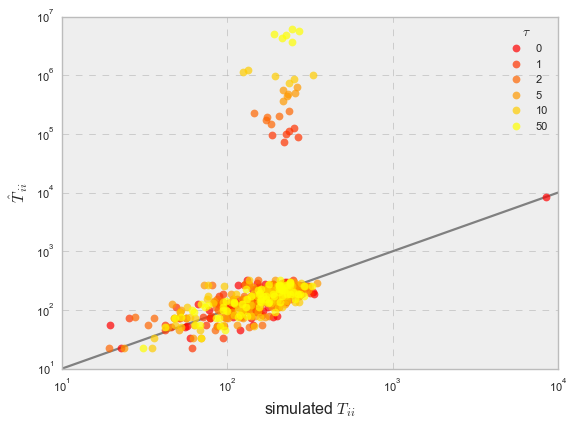

In [ ]:
plt.axline((100,100),slope=1,color='grey'); 
for it, t in enumerate([0,1,2,5,10,50]):
    coaltimec0 = get_haotime_w_c_t(coaltimemat['null'], 0.6, t*1000, 23, 56)
    plt.plot(np.diag(coaltimemat[t]),np.diag(coaltimec0),'o',color=cols(it),alpha=0.7,label=t); 
plt.legend(title=r'$\tau$'); plt.xlabel(r'simulated $T_{ii}$'); plt.ylabel(r'$\hat T_{ii}$'); #plt.loglog(); 
# coaltimec0 = get_haotime_w_c_t(coaltimenull,0.5,10,23,56)
# plt.plot(np.diag(coaltime10),np.diag(coaltimec0),'o',color=cols(4),alpha=0.7); plt.loglog()

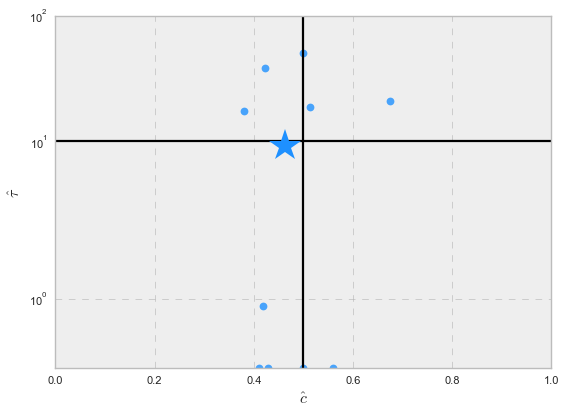

In [ ]:
# estsim = np.array([[4.10431916e-01, 7.92919862e-09],[ 0.42364001, 38.3736428 ],[5.60497931e-01, 1.93766894e-08],[0.49836902, 0.00139828],[ 0.512832  , 18.90176335],[ 0.50029511, 50.57321875],[ 0.67375107, 21.2205668 ],[0.41902669, 0.89104364],[0.42891996, 0.0015734 ],[ 0.38136416, 17.50254238]])
# est2 = np.array([[0.0334998 , 0.13675313],[5.59964908e-02, 4.99995511e+02],[0.06728984, 0.23588045],[0.04128836, 0.01456832],[0.06031066, 0.20734986],[ 0.8837989 , 11.31182538],[ 0.08061366, 51.05648748],[ 0.05596262, 40.1611428 ],[ 0.05552025, 20.33612972],[0.94979378, 0.00482244]])

plt.plot(estsim[:,0],estsim[:,1],'o',color='dodgerblue',alpha=0.8,label='est'); 
# plt.plot(est2[:,0],est2[:,1],'o',color='green',alpha=0.8,label=r'est2'); 
plt.xlabel(r'$\hat c$'); plt.ylabel(r'$\hat \tau$'); plt.axhline(10,color='k'); plt.axvline(0.5,color='k'); plt.xlim((0,1)); plt.yscale('symlog')
plt.plot(np.median(estsim[:,0]),np.median(estsim[:,1]),'*',markersize=30,color='dodgerblue'); 
# plt.plot(np.median(est2[:,0]),np.median(est2[:,1]),'*',markersize=30,color='green'); plt.ylim((-0.1,50)); plt.legend()

In [ ]:
# demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
#                                                    migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist())*0.1,
#                                                    ignore_sample_size=True, 
#                                                    Ne=100)
# demography.add_mass_migration(time=10, source=56, dest=23, proportion=0.5)
# for rep in range(10):
#     print(r"Rep {:d}: ".format(rep))
#     ts = msprime.sim_ancestry(
#             samples=[msprime.SampleSet(15,i,ploidy=2) for i in range(80)],
#             demography=demography,
#             sequence_length=700,
#             recombination_rate=0.001,  # No recombination
#             record_migrations=False, record_full_arg=False,
#             # model=[msprime.DiscreteTimeWrightFisher(duration=time_of_adm[0]+1), msprime.StandardCoalescent()],
#     )
#     print('done')

#     coaltimets10 = np.zeros((80,80))
#     for i in range(80):
#         for j in range(i,80):
#             coaltimets10[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
#             coaltimets10[j,i] = coaltimets10[i,j]

#     foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
#     print(sp.optimize.minimize(foo, [0.3, 50], method='Powell', bounds=[[0,1],[0,500]]))

#     foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t2(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
#     print(sp.optimize.minimize(foo, [0.3, 50], method='Powell', bounds=[[0,1],[0,500]]))

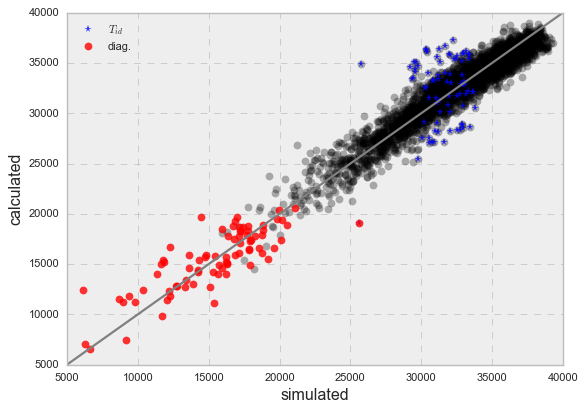

In [ ]:
# M = migmat - np.diag(np.diag(migmat))
coaltimec0 = get_haotime_w_c_t(coaltimetsnull, 0.0, 3., 23, 56)
# plt.plot(range(20),[get_coaltime_w_c_t(coaltimenull, 0.5, t, 23, 56)[56,56] for t in range(20)],'ko')
# coaltimec0[56,56], coaltimenull[56,56], coaltime3[56,56], coaltime10[56,56]
# foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
# sp.optimize.minimize(foo, [0.1, 1], method='Nelder-Mead', bounds=[[0,1],[0,500]]) # 1177.483480619133
# np.sqrt(np.mean((coaltimec0[np.tril_indices(80,0)]-coaltime10[np.tril_indices(80,0)])**2))
# plt.imshow(coaltimec0-coaltime10,cmap='RdBu'); plt.title(r'$\Delta T_{\tau=1}$'); plt.colorbar()
plt.plot((coaltimets30)[np.tril_indices(80,-1)],(coaltimec0)[np.tril_indices(80,-1)],'ko',alpha=0.3); plt.plot((coaltimets30)[56],(coaltimec0)[56],'b*',alpha=0.8,label=r'$T_{id}$'); plt.plot(np.diag(coaltimets30),np.diag(coaltimec0),'ro',alpha=0.8,label=r'diag.'); plt.axline((1.7e4,1.7e4),slope=1,color='grey'); plt.xlabel('simulated'); plt.ylabel('calculated'); plt.legend(loc='upper left'); 

# plt.plot((coaltimetsnull)[np.tril_indices(80,-1)],(coaltimec0)[np.tril_indices(80,-1)],'ko',alpha=0.3); plt.plot((coaltimetsnull)[56],(coaltimec0)[56],'b*',alpha=0.8,label=r'$T_{id}$'); plt.plot(np.diag(coaltimetsnull),np.diag(coaltimec0),'ro',alpha=0.8,label=r'diag.'); plt.axline((1.7e4,1.7e4),slope=1,color='grey'); plt.xlabel('simulated'); plt.ylabel('calculated'); plt.title(r"$T'_{\tau=0}$"); plt.legend(loc='upper left'); 
# plt.imshow(-50*(Q@np.diag(np.diag(dT0)) - migmat@dT0 - dT0@migmat),vmin=-4000,vmax=4000,cmap='RdBu'); plt.colorbar(); plt.title(r'$\Delta T_{\tau=50}$')

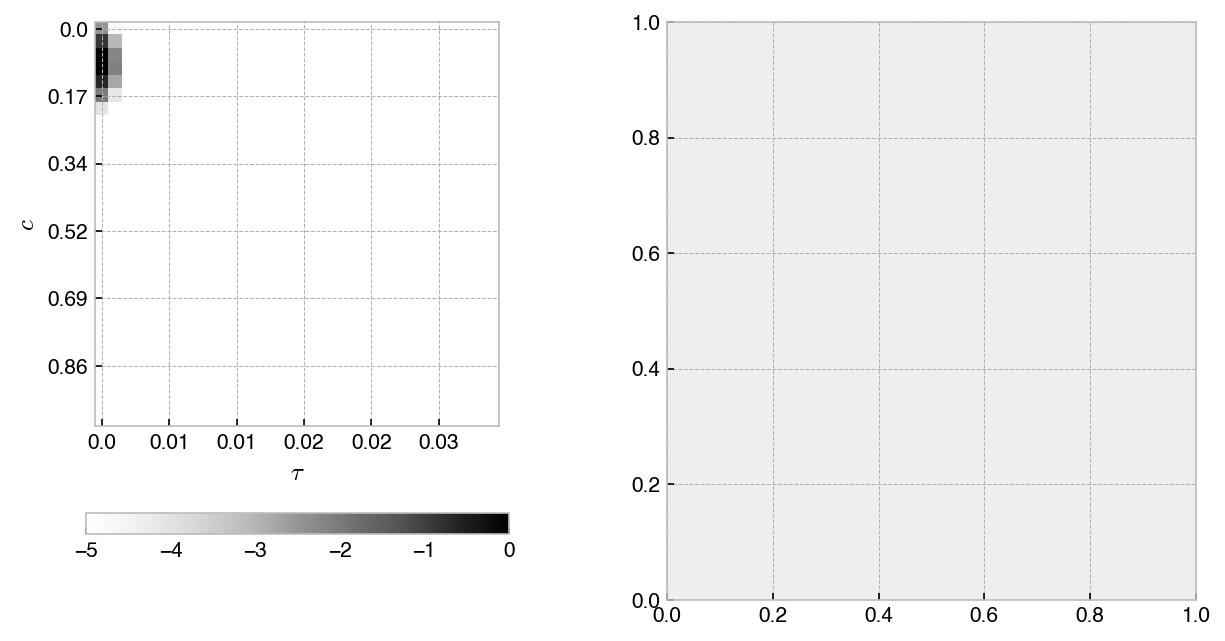

In [ ]:
cmesh = np.linspace(0,1,30); tmesh = np.linspace(0,0.03,30)
# # # foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
# # # foo2 = lambda x: np.sqrt(np.mean((get_haotime_w_c_t2(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
rmse = np.zeros((len(cmesh),len(tmesh))); rmse2 = np.zeros_like(rmse)
for ic, c in enumerate(cmesh):
    for it, t in enumerate(tmesh):
        # rmse[ic,it] = obj.neg_log_lik_c_t([0.99*c,t],{'lre':[(23,56)]}) #-foo([c,t])
        try:
            rmse[ic,it] = obj.neg_log_lik_c_t([c,t],{'lre':[(62,8)],'mode':'unsampled'})
        except:
            rmse[ic,it] = np.nan

# np.where(rmse==np.nanmin(rmse))

fig, ax1 = plt.subplots(1,1,figsize=(10,5),dpi=150); 
im = ax1.imshow(np.nanmin(rmse)-rmse,vmin=-5,cmap='Greys'); plt.colorbar(im, ax=ax1, orientation='horizontal', shrink=0.8); ax1.set_xlabel(r'$\tau$'); ax1.set_ylabel(r'$c$'); ax1.set_yticks(ticks=range(0,len(cmesh),5),labels=np.round(cmesh[::5],2)); ax1.set_xticks(ticks=range(0,len(tmesh),5),labels=np.round(tmesh[::5],2)); #ax1.plot(5,3,'r*'); ax1.axhline(9,color='k'); ax1.axvline(16,color='k'); #plt.show()

Text(0.5, 0, '$1/\\hat q$')

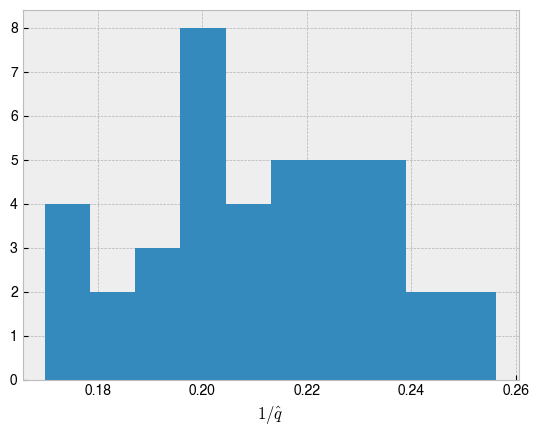

In [ ]:
# plt.plot([0,1,2,5,10,50],[-92,-2998,-5298,-7228,-7642,-5967],'o',color='coral',label='equilibrium eq.'); plt.plot([0,1,2,5,10,50],[-92,-2943,-5192,-6989,-7237,-5901],'*',color='deepskyblue',markersize=8,label='diffusion prob.'); plt.xlabel(r'$\tau$'); plt.ylabel(r'error in $T_{dd}$'); plt.axhline(0,color='grey'); plt.legend(); 

# plt.plot([0,1,2,5,10,50],[-17,-290,-117,139,290,-1289],'o',color='coral',label='equilibrium eq.'); plt.plot([0,1,2,5,10,50],[-17,-117,222,958,1827,3704],'*',color='deepskyblue',markersize=8,label='diffusion prob.'); plt.xlabel(r'$\tau$'); plt.ylabel(r'error in $T_{sd}$'); plt.axhline(0,color='grey'); plt.legend(); 

# plt.plot((coaltimenull+dTt)[np.tril_indices(80,-1)],coaltimec0[np.tril_indices(80,-1)],'o',color=cols(4),alpha=0.8); plt.axline((1e4,1e4),slope=1,color='grey'); plt.xlabel(r'equilibrium eq. estimates'); plt.ylabel(r'diffusion prob. estimates'); plt.title(r'$T_{ij}$ for $\tau=10$')
# plt.plot(np.diag(coaltimenull+dTt),np.diag(coaltimec0),'o',color=cols(4),alpha=0.8); plt.axline((1e3,1e3),slope=1,color='grey'); plt.xlabel(r'equilibrium eq. estimates'); plt.ylabel(r'diffusion prob. estimates'); plt.title(r'$T_{ij}$ for $\tau=10$')
plt.hist(1/sp_graph.q); plt.xlabel(r'$1/\hat q$')

/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_24476/2993223941.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=prod.max()), cmap=mpl.cm.Greys), orientation='horizontal', label='prob.'); plt.title(r'$\tau={}$'.format(tau))


Text(0.5, 1.0, '$\\tau=5000$')

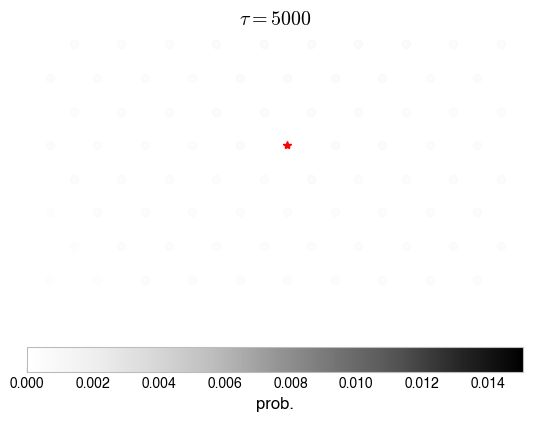

In [ ]:
# ## plotting the grid and seeing where lineages end up
tau = 5000
probmat = sp.linalg.expm(migmat*tau) # or sp.linalg.expm(-migmat*tau) @ np.diag(1/sp_graph.q) @ sp.linalg.expm(-migmat*tau) from Al-asadi et al 2019
prod = np.ravel(onehot @ probmat)
for i in range(80):
    plt.plot(grid_def[i,0],grid_def[i,1],'o',color='k',alpha=prod[i]); 
plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid(); plt.plot(grid_def[45,0],grid_def[45,1],'r*')
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=prod.max()), cmap=mpl.cm.Greys), orientation='horizontal', label='prob.'); plt.title(r'$\tau={}$'.format(tau))

In [ ]:
# def avg_coal_time(tree):
#     coalescence_time = 0
#     sample_size = tree.get_sample_size()
#     for leaves in tree.samples():
#         num_branch = 0
#         u = leaves
#         visited = np.array([u])
#         while u != tskit.NULL:
#             u = tree.parent(u)
#             if u !=-1 :
#                 node_children = np.array(tree.children(u))
#                     #print("{}:{}".format(u, node_children))                                                                                               
#                 node_interest = np.setdiff1d(node_children, visited)
#                 if len(node_interest)!=0:
#                     for j in range(len(node_interest)):
#                         num_leaves = tree.get_num_leaves(node_interest[j])
#                         node_branch_len = tree.time(u) * num_leaves
#                         coalescence_time = coalescence_time + node_branch_len
#                         visited = np.append(visited, u)
#                         num_branch =+ num_leaves

#         #print("leaves{}:{},{}".format(leaves, num_branch, visited))                                                                                       
#     return(coalescence_time/(sample_size * (sample_size-1)))

In [ ]:
# import tskit
## 8x10, Ne=1000, m=1e-3, n_samples_per_node=10, n_snps=500: tree{j}_8x10_c0_t0.tree
# mytree = []
# for j in np.arange(500):
#     mytree.append(tskit.load(f"/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/tree{j}_8x10_c0_t0.tree"))

In [ ]:
## reading in trees from SLiM (https://github.com/petrelharp/isolation_by_coalescence)
# origts = tskit.load("/Users/vivaswat/feems/docs/notebooks/results/slimtrees/pop_10000.trees")
# origtree = []
# for t in origts.trees():
#     origtree.append(t)

## how to compute just the diagonal elements of the coalescence time matrix?
dcoaltime = np.zeros(ndemes)
for snp in range(nsnps):
    tt = mytree[snp].first()
    for i in range(ninds*ndemes):
        for j in range(i+1,ninds*ndemes):
            if int(i/ninds) == int(j/ninds):
                dcoaltime[int(i/ninds)] += tt.tmrca(i,j)
            else:
                continue
dcoaltime /= np.sum(range(ninds))*ninds**2

# ndemes = 80; ninds = 2*10; nsnps = 500
# coaltimemat = np.zeros((ndemes,ndemes))
# for snp in range(nsnps):
#     tt = mytree[snp].first()
#     for i in range(ninds*ndemes):
#         for j in range(i+1,ninds*ndemes):
#             coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

# coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
# coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds

# coaltimemat = coaltimemat + coaltimemat.T
# coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
# coaltimemat /= nsnps

# ndemes = 36; ninds = 2*6; nsnps = 1000
# coaltimemat36 = np.zeros((ndemes,ndemes))
# for snp in range(nsnps):
#     tt = mytree[snp].first()
#     for i in range(ninds*ndemes):
#         for j in range(i+1,ninds*ndemes):
#             coaltimemat36[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

# coaltimemat36[np.diag_indices_from(coaltimemat36)] /= np.sum(range(ninds))
# coaltimemat36[np.triu_indices_from(coaltimemat36,1)] /= ninds*ninds

# coaltimemat36 = coaltimemat36 + coaltimemat36.T
# coaltimemat36[np.diag_indices_from(coaltimemat36)] *= 0.5
# coaltimemat36 /= nsnps

# for rep in range(3,16):
#     mytree = []
#     for j in np.arange(500):
#         mytree.append(tskit.load(f"feemsResults/trees/mytreewadms{j}_rep{rep}_tau1_c0.5.tree"))

#     print(f"Working on rep {rep}...")
#     coaltimemat = np.zeros((ndemes,ndemes))
#     for snp in range(nsnps):
#         tt = mytree[snp].first()
#         for i in range(ninds*ndemes):
#             for j in range(i+1,ninds*ndemes):
#                 coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)
    
#     coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
#     coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds
#     coaltimemat = coaltimemat + coaltimemat.T
#     coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
#     coaltimemat /= nsnps
#     np.savetxt(f"feemsResults/trees/coaltimemat{rep}t1c0.5.txt",coaltimemat)

# coaltimemattot = np.zeros((16,80,80))
# for rep in range(16):
#     coaltimemattot[rep,:,:] = np.loadtxt(f"feemsResults/trees/coaltimemat{rep}t1c0.5.txt")
# coaltimemat = np.mean(coaltimemattot,axis=0)
# coaltimemat = np.loadtxt(f"/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/trees/coaltimemat1t1c0.5.txt")